Affronteremo un problema di Classificazione.
![](image/02_classification.png)

Un problema di classificazione comprende il predire se un qualcosa appartiene a una "categoria" o un'altra

| Problem type | What is it? | Example|
|--------------|--------------|------|
| Binary classification | Target can be one of two options, e.g. yes or no | Predict whether or not someone has heart disease based on their health parameters.|
| Multi-class classification | Target can be one of more than two options | Decide whether a photo is of food, a person or a dog.|
| Multi-label classification | Target can be assigned more than one option | Predict what categories should be assigned to a Wikipedia article (e.g. mathematics, science & philosophy).|

Il barch size sarà di 32 ([tweet LeCun](https://x.com/ylecun/status/989610208497360896))
![](image/Lecun_batch.png)


## Architettura di un rete neurale di classificazione

| **Hyperparameter** | **Binary Classification** | **Multiclass classification**|
|----------------|-----------------------|---------------------------|
|**Input layer shape** (in_features) | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification|
|**Hidden layer(s)** | Problem specific, `minimum = 1`, `maximum = unlimited` | Same as binary classification |
| **Neurons per hidden layer** | Problem specific, generally 10 to 512 | Same as binary classification|
| **Output layer shape** (out_features) | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo)|
| **Hidden layer activation** | Usually `ReLU` (rectified linear unit) but can be many others | Same as binary classification|
| **Output activation** | Sigmoid (`torch.sigmoid` in PyTorch) | Softmax (`torch.softmax` in PyTorch)|
| **Loss function** | Binary crossentropy (`torch.nn.BCELoss` in PyTorch) | Cross entropy (`torch.nn.CrossEntropyLoss` in PyTorch)|
| **Optimizer** | 	SGD (stochastic gradient descent), Adam (see `torch.optim` for more options) | Same as binary classification|

# 1. Make classification data and get it ready

In [1]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

In [2]:
len(X), len(y)

(1000, 1000)

In [3]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [4]:
# Make dataframe of circle data

import pandas as pd
circles = pd.DataFrame({
    "X1": X[:,0],
    "X2": X[:,1],
    "label":y
})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [57]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

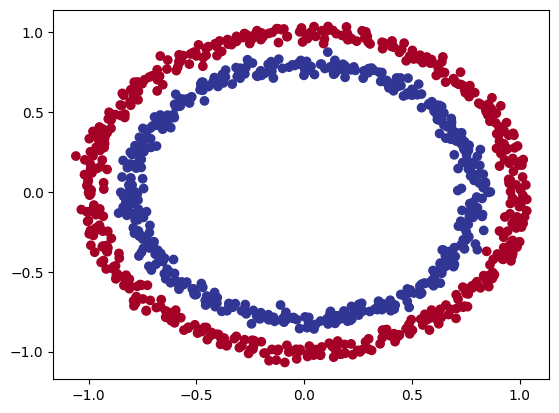

In [7]:
# Visualize visualize visualize
import matplotlib.pyplot as plt
plt.scatter(
    x = X[:,0],
    y = X[:,1],
    c=y,
    cmap=plt.cm.RdYlBu
)

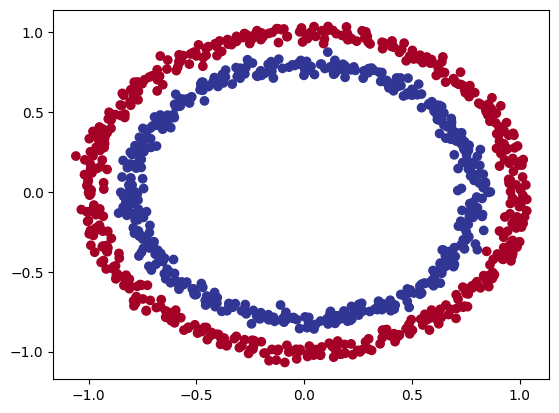

In [10]:
# Visualize visualize visualize (test con il dataframe)
import matplotlib.pyplot as plt
plt.scatter(
    x=circles["X1"],
    y=circles["X2"],
    c=circles["label"],
    cmap=plt.cm.RdYlBu
);

**Nota**: I dati con cui stiamo lavorando spesso vengono chiamati **toy dataset**, ovvero dataset piccoli per poter sperimentare ma della dimensione giusta per fare pratica.

### 1.1 Controllo della forma degli input e output
Abbiamo 1000 samples, con 2 feature per gli input e 1000 output con un unico valore

In [11]:
X.shape, y.shape

((1000, 2), (1000,))

In [12]:
# Visualizziamo il primo esempio di feature e label
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X (2,) and the same for y: ()


### 1.2 Convertire dati in tensori e creare train and test splits

In [14]:
import torch

torch.__version__

'2.7.0'

In [16]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [17]:
# Turn data into tensor
X = torch.from_numpy(X).type(torch.float) # float 32
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [18]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [20]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [21]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

1. setup device agnostic code (GPU or CPU)
2. Construct a model (subclassing `nn.Module`)
3. Define loss function and optimizer
4. Create training and test loop

In [4]:
import torch
from torch import nn

def get_device():
    if torch.backends.mps.is_available():
        return torch.device("mps")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# Poi usa
device = get_device()


In [5]:
print(device)

mps


Dopo aver imopstato il codice in modo *device agnostic*:
1. Subclass di `nn.Module`
2. Creare 2 layer `nn.Linear()` in modo tale da poter gestire la forma dei nostri dati
3. Definire un metodo `forward()` per effetturare il forward pass del modello
4. Instanziare un istanza della classe modello e mandarla sul `device` target
    

In [24]:
# 1 subclass
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2 crere 2 layer in modo da poter gestire la forma dei dati
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # out feature di solito multipli di 8 (upscaliamo per poter avere più patter per far imparare il modello)
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # prende le 5 feature del layer precedente e ne butta fuori 1 come output
    # 3 forward method per effetture il forward pass
    def forward(self,x):
        return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# 4 istanziare e mandare il modello sul device target
model_0 = CircleModelV0().to(device)

model_0
        
    

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [25]:
device

device(type='mps')

In [26]:
next(model_0.parameters()).device

device(type='mps', index=0)

Esempio visuale di cosa fare grazie al [Playground di TensorFlow](https://playground.tensorflow.org/)

Nel primo layer abbiamo impostato il ricevere 2 features come input e ne generiamo 5, quindi facciamo un **upscaling**.
Questo permette al modello di imparare pattern da 5 numeri e non da soli 2 numeri, per avere potenzialmente migliori output.

**Il numero di hidden layers** che possiamo usare in una rete neurale viene definito **hyperparameter** in quanto viene impostato da noi.
**Regola** con gli hidden layer, il layer successivo dovrà prendere come `in_feature` lo stesso numero di `out_features` del layer che lo precede.


![](image/02-tensorflow-playground-linear-activation.png)



**Possiamo ottenere lo stesso risultato usando `nn.Sequential()`**

Che permette di implementare senza creare la subclass. Ma il subclassing ci permette di gestire meglio le cose.

In [28]:
model_0_S = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0_S

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

**Per vedere i pesi e bias randomizzati iniziali:**

In [30]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.5280, -0.6383],
                      [ 0.0182, -0.1084],
                      [-0.5489,  0.6305],
                      [-0.5932,  0.1968],
                      [-0.1812,  0.6512]], device='mps:0')),
             ('layer_1.bias',
              tensor([-0.1380, -0.6508, -0.1989, -0.4496, -0.0237], device='mps:0')),
             ('layer_2.weight',
              tensor([[-0.3610,  0.2223, -0.4369,  0.0717,  0.4019]], device='mps:0')),
             ('layer_2.bias', tensor([-0.3328], device='mps:0'))])

In [33]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test sample: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test sample: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.3612],
        [-0.1792],
        [-0.6719],
        [-0.2738],
        [-0.4079],
        [-0.2988],
        [ 0.0043],
        [-0.0230],
        [-0.6825],
        [-0.1641]], device='mps:0')

First 10 labels labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Per un problema di **classificazione** non possiamo usare la metrica usata per la **regressione (MAE O MSE)**, molto probabilmente useremo la **binary cross entropy** o la **categorical Cross entropy**


| **Loss function/Optimizer** | **Problem type** | **PyTorch Code** |
|--------------------------|-------------|--------------|
| Stochastic Gradient Descent (SGD) optimizer | Classification, regression, many others. | `torch.optim.SGD()` |
| Adam Optimizer | Classification, regression, many others. | `torch.optim.Adam()` |
| Binary cross entropy loss | Binary classification | `torch.nn.BCELossWithLogits` or `torch.nn.BCELoss` |
| Cross entropy loss | Multi-class classification | `torch.nn.CrossEntropyLoss` |
| Mean absolute error (MAE) or L1 Loss | Regression | `torch.nn.L1Loss` |
| Mean squared error (MSE) or L2 Loss | Regression | `torch.nn.MSELoss` |


### Useremo `BCEWithLogitsLoss`
Vantaggi di BCEWithLogitsLoss

1. Stabilità numerica:

- `BCEWithLogitsLoss` combina in un'unica funzione l'attivazione sigmoide e la loss Binary Cross Entropy (BCE)
- Questa combinazione è implementata in modo numericamente più stabile rispetto all'applicazione separata di sigmoid e BCE


2. Maggiore efficienza:

- Evita il calcolo intermedio dell'attivazione sigmoide, ottimizzando le operazioni
- È più veloce perché utilizza trucchi matematici per calcolare direttamente la loss dai logits


3. Prevenzione di problemi di overflow/underflow:

- I valori molto grandi o molto piccoli nei logits possono causare problemi numerici quando si applica la sigmoide separatamente
- `BCEWithLogitsLoss` gestisce internamente questi casi limite


4. Supporto per pesi per classi sbilanciate:

- Permette di specificare facilmente pesi per gestire dataset sbilanciati
- È possibile passare un parametro `pos_weight` per dare più importanza alla classe positiva


5. Migliore per il backpropagation:

-Il gradiente è calcolato in modo più preciso, il che migliora l'apprendimento



- Esempio pratico
Ecco la differenza tra l'approccio separato e l'uso di `BCEWithLogitsLoss`:
- Approccio separato (meno stabile):
```
# Definizione del modello senza sigmoide finale
outputs = model(inputs)  # outputs sono logits (valori non normalizzati)
probs = torch.sigmoid(outputs)  # Applicazione della sigmoide
loss_fn = nn.BCELoss()  # Binary Cross Entropy normale
loss = loss_fn(probs, targets)  # Calcolo della loss
```
- Approccio con BCEWithLogitsLoss (più stabile):

```
# Definizione del modello senza sigmoide finale
outputs = model(inputs)  # outputs sono logits (valori non normalizzati)
loss_fn = nn.BCEWithLogitsLoss()  # Sigmoide + BCE in un'unica funzione
loss = loss_fn(outputs, targets)  # Calcolo diretto della loss dai logits
```


In [52]:
loss_fn = nn.BCEWithLogitsLoss() # ha già l'attivazione sigomoide

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

### Calculate accuracy

$\text{Accuracy}=\frac{\text{Numero di predizioni corrette}}{\text{Numero totale di predizioni}} ×100$

Ci dice su tot esempi, quale percentuale il nostro modello ha indovinato

In [12]:
def acuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

## 3 Train a model
- Training Loop
  1. forward pass,
  2. calculate the loss,
  3. zero grad,
  4. backpropagation,
  5. optimizer

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

I **raw logits** sono i valori di output non elaborati prodotti dall'ultimo strato di una rete neurale, prima che venga applicata qualsiasi funzione di attivazione finale (come sigmoid, softmax, ecc.).

Caratteristiche dei raw logits:

- **Non normalizzati**: Sono valori numerici che possono variare da `-∞ a +∞`, senza limiti di intervallo specifici
- **Non interpretabili come probabilità**: Non sono confinati nell'intervallo `[0,1]`, quindi non possono essere direttamente interpretati come probabilità
- **Rappresentano "fiducia" grezza**: Valori più alti (positivi) indicano maggiore confidenza del modello verso una classe, valori più bassi (negativi) indicano confidenza verso la classe opposta

COnvertiremo i raw **logits** in prediction probabilities tramite una funzione di attivazione ( **sigmoide** per binary cross entropy, **softmax** per una multiclass classification.

Dopo convertiremo le predizioni di probabilità a **prediction labels** o arrotondandole o con `argmax()`

In [46]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:10]
y_logits

tensor([[-0.3612],
        [-0.1792],
        [-0.6719],
        [-0.2738],
        [-0.4079],
        [-0.2988],
        [ 0.0043],
        [-0.0230],
        [-0.6825],
        [-0.1641]], device='mps:0')

In [47]:
y_test[:10]

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])

In [48]:
# Use the sigmoid activaction function on our model logits to turn into predictions probability
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4107],
        [0.4553],
        [0.3381],
        [0.4320],
        [0.3994],
        [0.4258],
        [0.5011],
        [0.4942],
        [0.3357],
        [0.4591]], device='mps:0')

Per i valori in probabilità dobbiamo performare un rounding:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [49]:
# Find the predicted labels 
y_preds = torch.round(y_pred_probs)

# In full (logits -> pre probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:10]))

# Check for quality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True, True, True, True, True, True],
       device='mps:0')


tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], device='mps:0')

In [50]:
y_test[:10]

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])

### 3.2 Building and training and testing loop

In [55]:
torch.manual_seed(42)
torch.mps.manual_seed(42)

# set numbero epochs
epochs = 100

# put data on target device
X_train, y_train = X_train.to(device), y_train.to(device)

X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and eval loop

for epoch in range(epochs):
    ### tDeprecationWarning
    model_0.train()

    # 1 forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2 calculate loss / accuracy
    loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss() si aspettta raw logits come input
                   y_train)
    # loss = loss_fn(torch.sigmoid(y_logits), # nn.BCELoss si aspettta prediction probabilities come input
    #              y_train)

    acc = acuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3 optimizer zero grad
    optimizer.zero_grad()

    # 4 loss backward (back propagation)
    loss.backward()
    
    # 5 optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1 forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2 calculate test loss / acc 
        test_loss = loss_fn(test_logits, y_test)
        test_acc = acuracy_fn(y_true=y_test, y_pred=test_pred)
    
    # print out what is happenin'
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71689, Acc: 49.25% | Test Loss: 0.72328, Test acc: 45.50%
Epoch: 10 | Loss: 0.70468, Acc: 46.00% | Test Loss: 0.71224, Test acc: 49.00%
Epoch: 20 | Loss: 0.69995, Acc: 47.75% | Test Loss: 0.70758, Test acc: 48.00%
Epoch: 30 | Loss: 0.69777, Acc: 48.62% | Test Loss: 0.70510, Test acc: 49.00%
Epoch: 40 | Loss: 0.69656, Acc: 49.50% | Test Loss: 0.70347, Test acc: 48.50%
Epoch: 50 | Loss: 0.69576, Acc: 49.88% | Test Loss: 0.70223, Test acc: 48.50%
Epoch: 60 | Loss: 0.69519, Acc: 50.25% | Test Loss: 0.70122, Test acc: 48.50%
Epoch: 70 | Loss: 0.69475, Acc: 50.12% | Test Loss: 0.70038, Test acc: 48.50%
Epoch: 80 | Loss: 0.69441, Acc: 50.12% | Test Loss: 0.69967, Test acc: 48.00%
Epoch: 90 | Loss: 0.69413, Acc: 50.12% | Test Loss: 0.69907, Test acc: 48.50%


## 4 Make predictions and evaluate the model

Dalle metriche il nostro modello non sta imparando **una cippa**. un accuracy del 50% equivale a tirare a indovinare....

Proviamo a fare delle predizioni e renderle visivamente

Per farlo importiamo una funzione chiamata `plot_decision_boundary()` dalla repo del corso https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [16]:
import requests
from pathlib import Path


# download 
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Download helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary
    

helper_functions.py already exists, skipping download


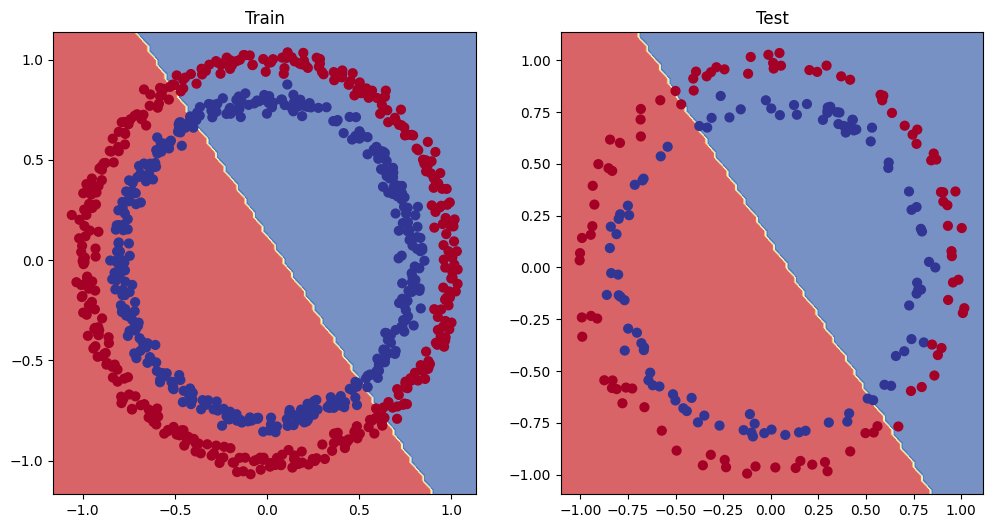

In [61]:
# Plot decision boundary of the model

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")

plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)


Dal grafico capiamo il problema, il modello sta cercando di fare previsioni solo con layer lineari.

### 5 Improving a model (from a model perspective)
- Add **more layers** - dare al modello più possibilità di imparare sui patterns nei dati
- Add **more hidden units** - da 5 unità nascoste a 10 unità nascoste.
- **Fit for longer** (aumentare epochs)
- Changing the **activation functions** (combinare i layer lineari con le funzioni di attivazioni es ReLU)
- Change the **learning rate**
- Change the **loss function**


| **Model improvement technique** | **What does it do?**|
|-----------------------------------|---------------------|
| **Add more layers** | Each layer potentially increases the learning capabilities of the model with each layer being able to learn some kind of new pattern in the data. More layers are often referred to as making your neural network deeper.|
| **Add more hidden units** | Similar to the above, more hidden units per layer means a potential increase in learning capabilities of the model. More hidden units are often referred to as making your neural network wider.|
| **Fitting for longer (more epochs)** | Your model might learn more if it had more opportunities to look at the data.|
| **Changing the activation functions** | Some data just can't be fit with only straight lines (like what we've seen), using non-linear activation functions can help with this (hint, hint).|
| **Change the learning rate** | Less model specific, but still related, the learning rate of the optimizer decides how much a model should change its parameters each step, too much and the model overcorrects, too little and it doesn't learn enough.|
| **Change the loss function** | Again, less model specific but still important, different problems require different loss functions. For example, a binary cross entropy loss function won't work with a multi-class classification problem.|
| **Use transfer learning** | Take a pretrained model from a problem domain similar to yours and adjust it to your own problem.|


Tutte queste opzioni sono da una "prospettiva" del modello in quanto sono direttamente legate ad esso  piuttosto che ai dati.

E anche perché queste opzioni sono tutti valori che(come machine learning enigneers e data scientist) possiamo cambiare, e vengono definiti **Iperparametri**

In [18]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 =  nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        # z = self.layer_1(x)
        # z = self.layer_2(x)
        # z = self.layer_3(x)
    # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)

model_1
        

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [65]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='mps:0')),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='mps:0')),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222,

In [64]:
next(model_1.parameters())

Parameter containing:
tensor([[ 0.5406,  0.5869],
        [-0.1657,  0.6496],
        [-0.1549,  0.1427],
        [-0.3443,  0.4153],
        [ 0.6233, -0.5188],
        [ 0.6146,  0.1323],
        [ 0.5224,  0.0958],
        [ 0.3410, -0.0998],
        [ 0.5451,  0.1045],
        [-0.3301,  0.1802]], device='mps:0', requires_grad=True)

In [66]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                           lr=0.1)

In [67]:
# Write a trininig and evaluation loop for model_1
torch.manual_seed(42)
torch.mps.manual_seed(42)

epochs = 1000

# put data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### training
    model_1.train()
    # 1 forward
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probabilities -> pred labels

    # 2 loss
    loss = loss_fn(y_logits, y_train)
    acc = acuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3 Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backpropagation
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()

    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)

        acc = acuracy_fn(y_true=y_test, y_pred=test_pred)


    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Loss: {loss:.5f} | Accuracy : {acc:.2f}% | test loss: {test_loss:.5f} | Test acc {test_acc:.2f}%")
        


Epoch 0 | Loss: 0.69396 | Accuracy : 51.00% | test loss: 0.69261 | Test acc 48.50%
Epoch 100 | Loss: 0.69305 | Accuracy : 48.00% | test loss: 0.69379 | Test acc 48.50%
Epoch 200 | Loss: 0.69299 | Accuracy : 46.00% | test loss: 0.69437 | Test acc 48.50%
Epoch 300 | Loss: 0.69298 | Accuracy : 45.00% | test loss: 0.69458 | Test acc 48.50%
Epoch 400 | Loss: 0.69298 | Accuracy : 46.00% | test loss: 0.69465 | Test acc 48.50%
Epoch 500 | Loss: 0.69298 | Accuracy : 46.00% | test loss: 0.69467 | Test acc 48.50%
Epoch 600 | Loss: 0.69298 | Accuracy : 46.00% | test loss: 0.69468 | Test acc 48.50%
Epoch 700 | Loss: 0.69298 | Accuracy : 46.00% | test loss: 0.69468 | Test acc 48.50%
Epoch 800 | Loss: 0.69298 | Accuracy : 46.00% | test loss: 0.69468 | Test acc 48.50%
Epoch 900 | Loss: 0.69298 | Accuracy : 46.00% | test loss: 0.69468 | Test acc 48.50%


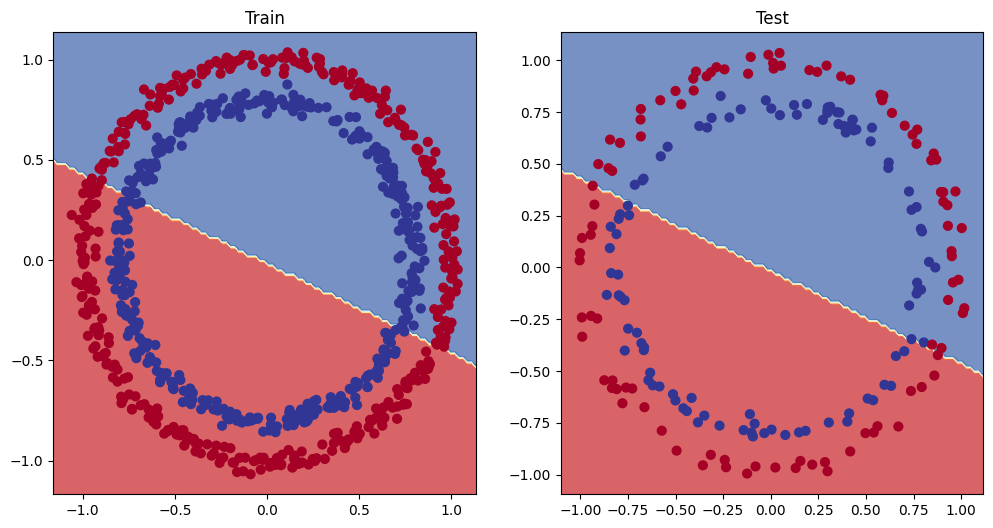

In [68]:
# Plot decision boundary of the model

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to ssee if our model can fit a straight line

Giustamente il modello continua a non imparare perché non stiamo facendo altro che una regressione.....

In [69]:
# Create some data 
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# create data

X_regression = torch.arange(start,end,step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias 

# check the data
print(len(X_regression))

X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [70]:
# create train and test split

train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

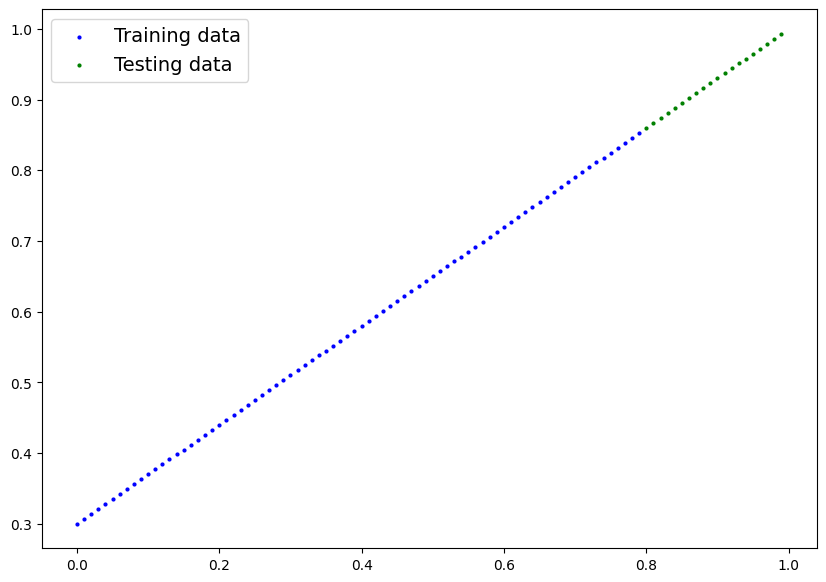

In [71]:
plot_predictions(train_data=X_train_regression, train_labels=y_train_regression, test_data=X_test_regression, test_labels=y_test_regression)

### 5.2 Adjusting `model_1` to fit a stright line

In [72]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10,out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [73]:
# Loss and optimizer

loss_fn = nn.L1Loss() # MAE loss with regression data
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)


In [74]:
# train loop
torch.manual_seed(42)
torch.mps.manual_seed(42)

epochs = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# train loop
for epoch in range(epochs):
    model_2.train()
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ## testing
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

    # print 
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")
    

Epoch 0 | Loss: 0.75986 | Test Loss: 0.54143
Epoch 100 | Loss: 0.09309 | Test Loss: 0.02901
Epoch 200 | Loss: 0.07376 | Test Loss: 0.02850
Epoch 300 | Loss: 0.06745 | Test Loss: 0.00615
Epoch 400 | Loss: 0.06107 | Test Loss: 0.02004
Epoch 500 | Loss: 0.05698 | Test Loss: 0.01061
Epoch 600 | Loss: 0.04857 | Test Loss: 0.01326
Epoch 700 | Loss: 0.06109 | Test Loss: 0.02127
Epoch 800 | Loss: 0.05599 | Test Loss: 0.01426
Epoch 900 | Loss: 0.05571 | Test Loss: 0.00603


In [ ]:
# turn on evalutaion

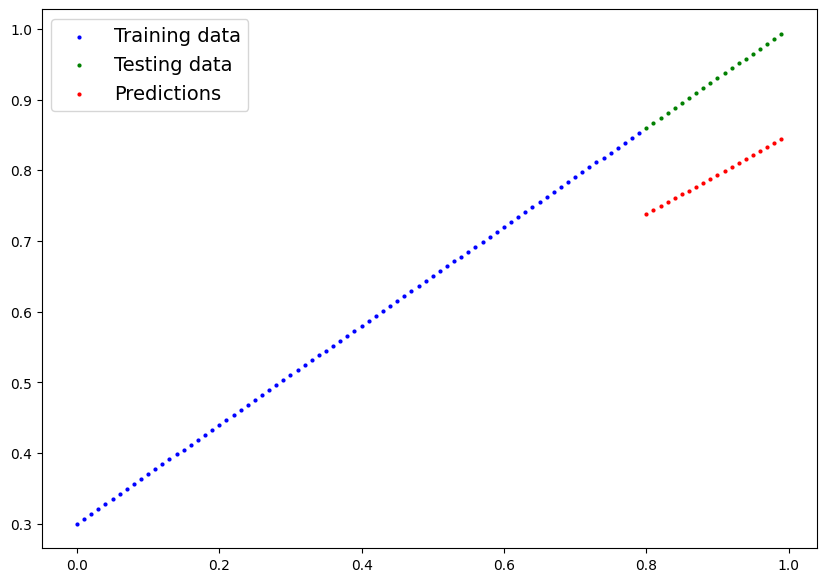

In [76]:
model_2.eval()

with torch.inference_mode():
    y_preds = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression.cpu(), train_labels=y_train_regression.cpu(), test_data=X_test_regression.cpu(), test_labels=y_test_regression.cpu(), predictions=y_preds.cpu())

### 6 The missing piece: Non linearity

#### 6.1 recreating non linear data

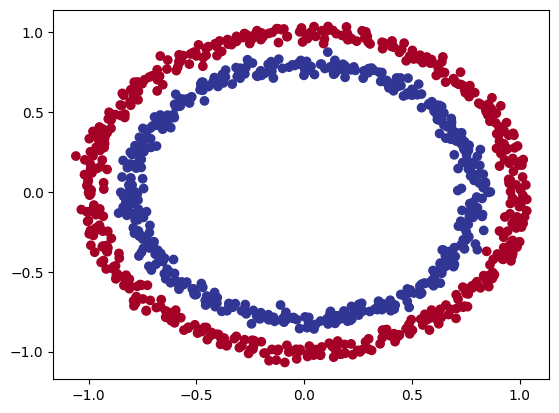

In [6]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [7]:
# Convert data to tensors and then to train and test splits

import torch
from sklearn.model_selection import train_test_split


X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=42)

X_train[:5],y_train[:5]

(tensor([[-0.0597, -0.9970],
         [-0.5320,  0.5567],
         [ 0.9656, -0.4018],
         [ 0.0764,  0.7993],
         [ 0.6488,  0.4942]]),
 tensor([0., 1., 0., 1., 1.]))

In [8]:
### 6.2 building a model with non linearity ( E finalmente)
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self,x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [9]:
model_3.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.0373, -0.6671],
                      [-0.2352, -0.1492],
                      [-0.4317, -0.6265],
                      [ 0.5660, -0.1713],
                      [-0.2263,  0.6210],
                      [-0.6189, -0.5651],
                      [-0.1845,  0.2350],
                      [ 0.7015,  0.3720],
                      [-0.3405,  0.2038],
                      [ 0.0677,  0.5495]], device='mps:0')),
             ('layer_1.bias',
              tensor([-0.4016, -0.1383,  0.3694, -0.3559,  0.0167,  0.3680, -0.6265,  0.6826,
                      -0.6627,  0.3411], device='mps:0')),
             ('layer_2.weight',
              tensor([[-0.1136,  0.1423, -0.0594, -0.3115, -0.2102,  0.2859,  0.1315, -0.3002,
                       -0.1625,  0.2625],
                      [-0.2337,  0.1423, -0.1233, -0.0249,  0.2799, -0.0298,  0.1532, -0.2225,
                        0.0478,  0.1577],
                      [-0.0472, -0.1228,

![](image/02-tensorflow-playground-relu-activation.png)

In [10]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.3)

In [13]:
### 6.3 training a model with non linearity

torch.manual_seed(42)
torch.mps.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


epochs = 1000

for epoch in range(epochs):
    ### training
    model_3.train()

    # 1 forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # raw logits -> prediction probs -> prediction labels

    # 2. Loss & accuracyabs
    loss = loss_fn(y_logits, y_train)
    acc = acuracy_fn(y_train, y_pred)

    # 3 .Optimizer zero grad
    optimizer.zero_grad()

    # 4. back propagation
    loss.backward()

    # 5. Optimizer
    optimizer.step()

    ### Testing

    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = acuracy_fn(y_test, test_pred)

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Loss {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc {test_acc:.2f}%")

Epoch 0 | Loss 0.69850 | Acc: 48.00% | Test Loss: 0.69497 | Test Acc 50.50%
Epoch 100 | Loss 0.68105 | Acc: 62.50% | Test Loss: 0.68951 | Test Acc 56.25%
Epoch 200 | Loss 0.64101 | Acc: 63.50% | Test Loss: 0.66587 | Test Acc 57.88%
Epoch 300 | Loss 0.44026 | Acc: 94.00% | Test Loss: 0.46647 | Test Acc 91.75%
Epoch 400 | Loss 0.38912 | Acc: 78.00% | Test Loss: 0.38660 | Test Acc 77.25%
Epoch 500 | Loss 0.07879 | Acc: 100.00% | Test Loss: 0.10392 | Test Acc 99.12%
Epoch 600 | Loss 0.03652 | Acc: 100.00% | Test Loss: 0.05866 | Test Acc 99.38%
Epoch 700 | Loss 0.02218 | Acc: 100.00% | Test Loss: 0.04248 | Test Acc 99.50%
Epoch 800 | Loss 0.01543 | Acc: 100.00% | Test Loss: 0.03427 | Test Acc 99.50%
Epoch 900 | Loss 0.01162 | Acc: 100.00% | Test Loss: 0.02934 | Test Acc 99.50%


### 6.4 Evaluating a model trianed with non -linear activation functions

In [14]:
# Makes prediction

model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='mps:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='mps:0'))

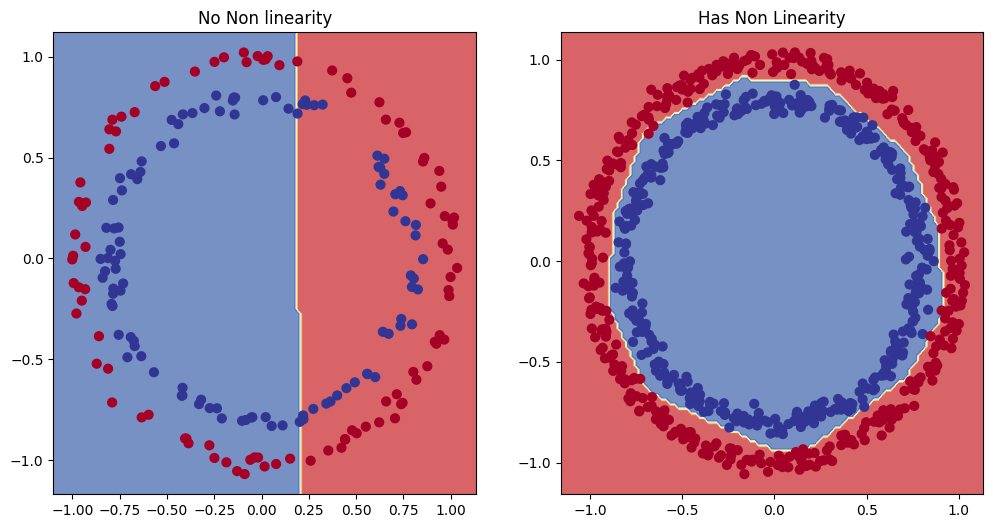

In [20]:
# plot decision bounderies

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("No Non linearity")
plot_decision_boundary(model_1, X_train, y_train) # model 1 no non linearity
plt.subplot(1,2,2)
plt.title("Has Non Linearity")
plot_decision_boundary(model_3, X_test, y_test) # model 3 has non linearity

### 7. Replicating non linear Activation function
Le reti neurali funzionano con una combinazione di funzioni lineari e non lineari.



In [23]:
# create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [24]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

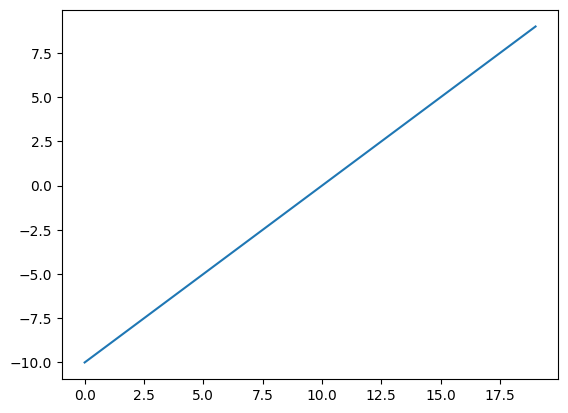

In [25]:
# Visualize the tensor
plt.plot(A)

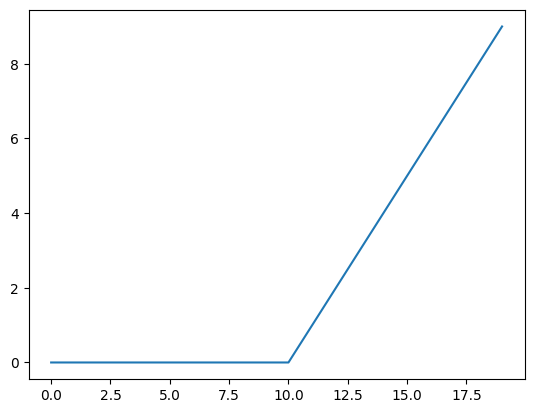

In [26]:
plt.plot(torch.relu(A))

la **ReLU** trasforma tutti i valori negativi in 0 e lascia quelli positivi invariati

Formula: $f(x) = max(0, x)$

✔️ Veloce da calcolare, evita il problema del gradiente che si annulla nei valori positivi.


In [28]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x) 

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

In [29]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

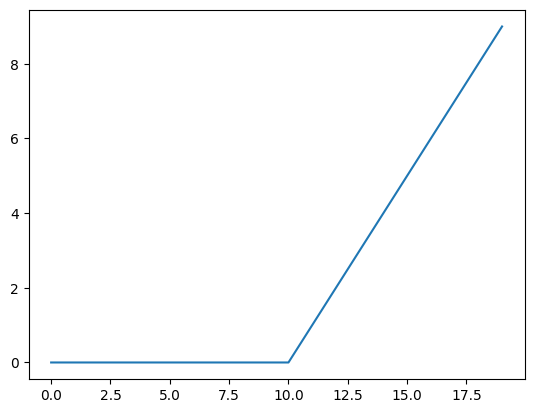

In [34]:
plt.plot(relu(A))

Un'altra funzione non lineare che abbiamo usato è la **sigmoide**

Comprende l’input in un range tra 0 e 1, rendendolo utile per probabilità.

Formula: $f(x) =\frac{1}{(1 + e^{-x})}$

- ✔️ Buona per classificazioni binarie,
- ⚠️ ma può causare gradienti molto piccoli (vanishing gradient) se l’input è troppo grande o troppo piccolo.

In [30]:
def sigmoid(x):
    return 1/(1 +torch.exp(-x))

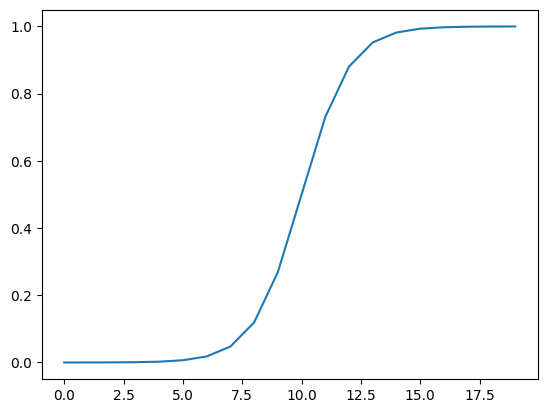

In [32]:
plt.plot(torch.sigmoid(A))

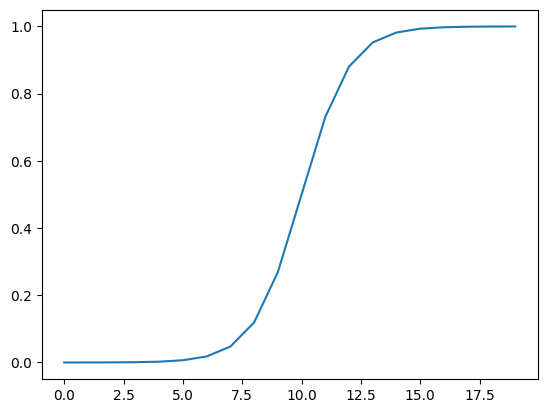

In [33]:
plt.plot(sigmoid(A))

### 8 putting all together with a multi class classification problem
- Binary classification = una cosa o un altra (cane vs gatto, spam vs non spam, fraud or not fraud)
- Multi-class classification = Più di una cosa o un'altra es cane vs gatto vs pollo

### 8.1 creating a toy multi-class dataset

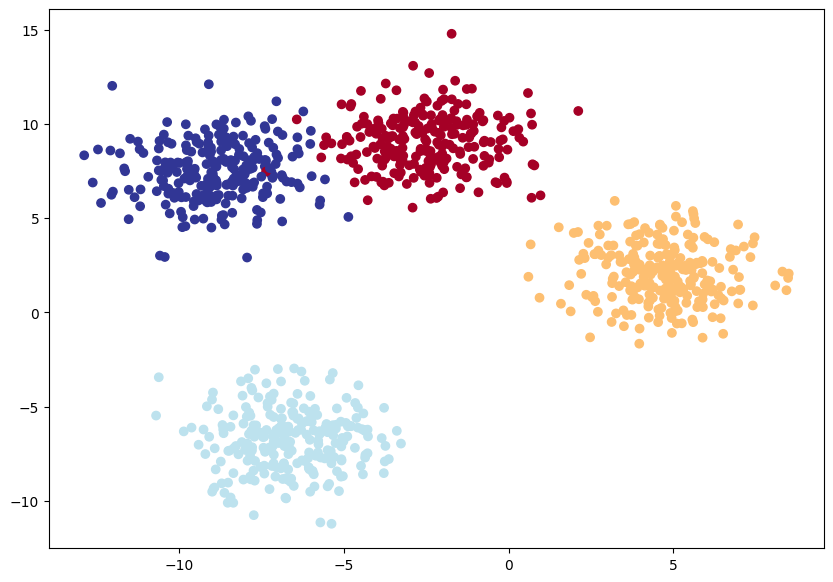

In [38]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# set the hyper parameters for data creation
NUM_CLASS = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi class data

X_blob, y_blob = make_blobs(n_samples= 1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASS,
                            cluster_std=1.5, # diamo a cluster una piccola shekerata
                            random_state=RANDOM_SEED)

# 2. turn data into tensor
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4 Plot Data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1],c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multi claass classification model in Pytorch

In [39]:
def get_device():
    if torch.backends.mps.is_available():
        return torch.device("mps")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# Poi usa
device = get_device()

In [40]:
device

device(type='mps')

In [53]:
# Build a multi-class classification model

class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """
        Initialized muli-class classification model.
        Args:
            input_features (int): Number of input features of the model
            output_features (int): Number of outputs features (number of output classes)
            hidden_units (int): Number of hidden units beetween layers, default 8
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    def forward(self,x):
        return self.linear_layer_stack(x)

# Create an istance of Blob Model and send it to target device

model_4 = BlobModel(input_features=2,
                   output_features=4,
                   hidden_units=8).to(device)


model_4


        

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [54]:
X_blob_train.shape, y_blob_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [55]:
torch.unique(y_blob_train)

tensor([0., 1., 2., 3.])

### 8.3 Setting up loss function and optmizer for a multi class classification model
La cross-entropy loss (perdita di entropia incrociata) è una funzione di costo usata nei problemi di classificazione. Misura la differenza tra le probabilità previste dal modello e le etichette reali (che sono codificate come distribuzioni one-hot).

1. 🧠 Intuizione:

Ti penalizza di più quanto più sei sicuro e sbagliato nella previsione.

2. 🧮 Formula (classificazione binaria):

$\text{Loss} = - \left[ y \cdot \log(p) + (1 - y) \cdot \log(1 - p) \right]$

- y: etichetta vera (0 o 1)
- p: probabilità prevista per la classe positiva

3. 📦 Multiclasse (con softmax):

$\text{Loss} = - \sum_{i=1}^{C} y_i \cdot \log(p_i)$
- C: numero di classi
- $y_i$: 1 per la classe corretta, 0 altrimenti
- $p_i$: probabilità prevista per la classe i


In [56]:
# Create a loss function
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_4.parameters(),
                           lr=0.1)

### 8.4 Getting prediction probabilities for a multi class PyTorch Model
Per poter allenare, testare e valutare il modello, dobbiamo convertire gli output del modello (logits) in prediction probabilities e dopo in prediction labels.

**Logits** (raw output of the model) -> **Pred probs** (use `torch.softmax`) -> **Pred Labels** (taake the `argmax` of the prediction probabilites)

Essendo multiclass non usiamo più la **Sigmoid** ma la **Softmax**

In [61]:
X_blob_test.device

device(type='cpu')

In [62]:
# Let's get some raw output
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.3991,  0.4134,  0.1665,  0.1832],
        [-0.9233,  0.3555,  0.7643,  0.1386],
        [-1.1176,  0.1433,  0.9499, -0.2512],
        [-0.2603,  0.3470,  0.1297,  0.1965],
        [-0.4402,  0.4431,  0.2003,  0.1548],
        [-1.0856,  0.3873,  0.8992,  0.1162],
        [-0.9570,  0.0256,  0.9414, -0.3209],
        [-0.5470,  0.2516,  0.3147,  0.1583],
        [-1.4694,  0.2682,  1.0433, -0.1624],
        [-0.5013,  0.3200,  0.2702,  0.1577]], device='mps:0')

In [60]:
y_blob_test[:10]

tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0.])

In [65]:
# Convert our model's logits outputs to prediction probabilities

y_pred_probs = torch.softmax(y_logits, dim = 1)

print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.3991,  0.4134,  0.1665,  0.1832],
        [-0.9233,  0.3555,  0.7643,  0.1386],
        [-1.1176,  0.1433,  0.9499, -0.2512],
        [-0.2603,  0.3470,  0.1297,  0.1965],
        [-0.4402,  0.4431,  0.2003,  0.1548]], device='mps:0')
tensor([[0.1470, 0.3312, 0.2587, 0.2631],
        [0.0776, 0.2787, 0.4194, 0.2243],
        [0.0675, 0.2382, 0.5337, 0.1606],
        [0.1697, 0.3116, 0.2507, 0.2680],
        [0.1403, 0.3393, 0.2661, 0.2543]], device='mps:0')


**Per ogni valore se sommiamo i 4, otteniamo 1**

In [66]:
torch.sum(y_pred_probs[0])

tensor(1., device='mps:0')

In [67]:
torch.max(y_pred_probs[0])

tensor(0.3312, device='mps:0')

In [68]:
torch.argmax(y_pred_probs[0])

tensor(1, device='mps:0')

In [69]:
# convert our model's prediction probabilities to predicion labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,
        2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2,
        2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
        1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2,
        2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2,
        1, 2, 2, 2, 2, 1, 2, 1], device='mps:0')

In [71]:
y_blob_test

tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0., 0., 1., 0., 0., 0., 3., 3., 2.,
        3., 3., 3., 0., 1., 2., 2., 2., 3., 0., 1., 0., 3., 1., 1., 3., 1., 2.,
        1., 3., 0., 2., 0., 3., 3., 2., 0., 3., 1., 1., 0., 3., 1., 0., 1., 1.,
        3., 2., 1., 1., 3., 2., 2., 0., 3., 2., 2., 0., 0., 3., 3., 0., 0., 3.,
        3., 3., 2., 3., 3., 3., 3., 1., 0., 2., 3., 2., 3., 3., 2., 3., 3., 2.,
        3., 3., 1., 3., 3., 3., 1., 0., 3., 2., 0., 0., 3., 0., 2., 3., 1., 0.,
        3., 2., 1., 1., 0., 2., 2., 3., 0., 0., 1., 2., 2., 3., 0., 1., 2., 0.,
        0., 0., 2., 3., 1., 2., 3., 2., 0., 3., 0., 0., 1., 1., 1., 0., 2., 2.,
        2., 2., 0., 3., 3., 2., 2., 1., 3., 2., 0., 0., 3., 3., 2., 1., 2., 0.,
        3., 2., 0., 3., 2., 0., 2., 2., 2., 0., 3., 1., 1., 1., 1., 1., 3., 1.,
        0., 2., 2., 1., 2., 2., 0., 1., 2., 2., 0., 0., 1., 3., 2., 0., 3., 1.,
        2., 1.])

### 8.5 Creating a training loop and testing loop for a multi-claass PyTorch Model

In [74]:
# Fit the multi-class model to the data

torch.manual_seed(RANDOM_SEED)
torch.mps.manual_seed(RANDOM_SEED)

epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

## Loop 
for epoch in range(epochs):
    ### training
    model_4.train()

    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim = 1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = acuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()


    ### testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim = 1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        acc = acuracy_fn(y_true=y_blob_test, y_pred=test_preds)

    # Print 
    if epoch % 10 == 0:
        print(f"Epoch : {epoch} | Loss: {loss:.4f} | Acc: {acc:.2f}% | Test loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

Epoch : 0 | Loss: 1.1355 | Acc: 47.00% | Test loss: 1.0113 | Test Acc: 99.62%
Epoch : 10 | Loss: 0.6805 | Acc: 89.50% | Test loss: 0.6410 | Test Acc: 99.62%
Epoch : 20 | Loss: 0.3959 | Acc: 99.00% | Test loss: 0.3477 | Test Acc: 99.62%
Epoch : 30 | Loss: 0.1789 | Acc: 99.50% | Test loss: 0.1493 | Test Acc: 99.62%
Epoch : 40 | Loss: 0.0934 | Acc: 99.50% | Test loss: 0.0756 | Test Acc: 99.62%
Epoch : 50 | Loss: 0.0632 | Acc: 99.50% | Test loss: 0.0495 | Test Acc: 99.62%
Epoch : 60 | Loss: 0.0499 | Acc: 99.50% | Test loss: 0.0379 | Test Acc: 99.62%
Epoch : 70 | Loss: 0.0428 | Acc: 99.50% | Test loss: 0.0316 | Test Acc: 99.62%
Epoch : 80 | Loss: 0.0385 | Acc: 99.50% | Test loss: 0.0278 | Test Acc: 99.62%
Epoch : 90 | Loss: 0.0357 | Acc: 99.50% | Test loss: 0.0253 | Test Acc: 99.62%


### 8.6 Making and evaluaating predictions with A PyTorch multi-class model

In [76]:
# Make prediction
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_logits[:10]
    

tensor([[ 1.3418,  6.3180, -3.6990, -2.2402],
        [-0.5958, -3.1406, -0.9196,  4.7868],
        [-4.0203, -6.3010,  7.0586, -1.3679],
        [-0.7549,  4.4443, -2.0350, -0.8695],
        [ 8.3979,  3.7863, -4.7598, -3.6477],
        [-1.0262, -3.9598, -0.8992,  5.7936],
        [-3.2623, -5.5708,  6.8221, -2.2256],
        [ 7.1113,  1.1672, -3.5916, -1.6410],
        [-5.3690, -7.7959,  7.9637, -0.3810],
        [ 7.5832,  2.0099, -3.9491, -2.3395]], device='mps:0')

In [77]:
# go from logits -> prediction probabilitisies
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[6.8511e-03, 9.9291e-01, 4.4316e-05, 1.9059e-04],
        [4.5584e-03, 3.5775e-04, 3.2975e-03, 9.9179e-01],
        [1.5431e-05, 1.5772e-06, 9.9976e-01, 2.1895e-04],
        [5.4553e-03, 9.8816e-01, 1.5167e-03, 4.8646e-03],
        [9.9015e-01, 9.8378e-03, 1.9115e-06, 5.8122e-06],
        [1.0894e-03, 5.7962e-05, 1.2368e-03, 9.9762e-01],
        [4.1719e-05, 4.1473e-06, 9.9984e-01, 1.1764e-04],
        [9.9721e-01, 2.6140e-03, 2.2415e-05, 1.5764e-04],
        [1.6203e-06, 1.4308e-07, 9.9976e-01, 2.3760e-04],
        [9.9616e-01, 3.7833e-03, 9.7699e-06, 4.8858e-05]], device='mps:0')

In [82]:
# go from prediction probabilitisies -> prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:20]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3],
       device='mps:0')

In [81]:
y_blob_test[:20]

tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0., 0., 1., 0., 0., 0., 3., 3., 2.,
        3., 3.], device='mps:0')

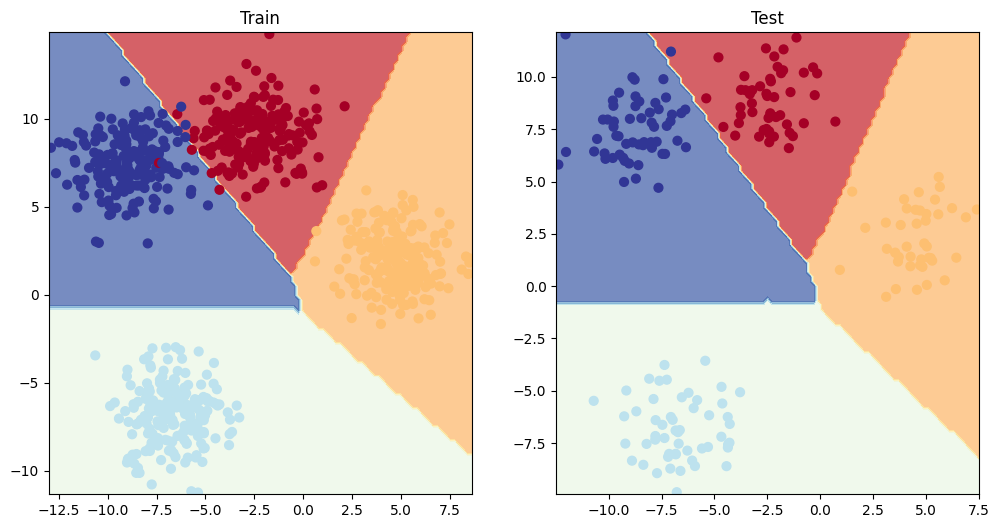

In [83]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

### 9 A few more classification metrix
| Metric name/Evaluation method | Formula | Defintion | Code |
|-------------------------------|----------|-----------|------|
| **Accuracy** | $Accuracy= \frac{tp+tn}{tp+tn+fp+fn}$| Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct. | `torchmetrics.Accuracy()` or `sklearn.metrics.accuracy_score()` |
| **Precision** | $Precision=\frac{tp}{tp+fp}$| Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0). | `torchmetrics.Precision()` or `sklearn.metrics.precision_score()`|
| **Recall** | $Recall=\frac{tp}{tp+fn}$|Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives. | `torchmetrics.Recall()` or `sklearn.metrics.recall_score()`|
| **F1-score** | $\text{F1-score}=2*\frac{precision*recall}{precision+recall}$ | Combines precision and recall into one metric. 1 is best, 0 is worst. | `torchmetrics.F1Score()` or `sklearn.metrics.f1_score()`|
| **Confusion matrix** | NA | Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line). | `torchmetrics.ConfusionMatrix` or `sklearn.metrics.plot_confusion_matrix()` |
| **Classification report** | NA | Collection of some of the main classification metrics such as precision, recall and f1-score. | `sklearn.metrics.classification_report()`|

## Exercise
1. Make a binary classification dataset with Scikit-Learn's make_moons() function.
- For consistency, the dataset should have 1000 samples and a random_state=42.
- Turn the data into PyTorch tensors.
- Split the data into training and test sets using train_test_split with 80% training and 20% testing.

In [107]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)

In [108]:
X.shape, y.shape

((1000, 2), (1000,))

In [109]:
# Turn data into a DataFrame
import pandas as pd
df = pd.DataFrame(data=X, columns=['x1', 'x2'])
df['label'] = y  # aggiungi la colonna target

# oppure con un dizionario
# df = pd.DataFrame({
#     'x1': X[:, 0],
#     'x2': X[:, 1],
#     'label': y
# })
df.head()

,x1,x2,label
0,-0.111667,0.520224,1
1,1.142650,-0.342577,1
2,0.795558,-0.011442,1
3,0.111827,-0.551932,1
4,-0.816466,0.543996,0


In [110]:
df['label'].value_counts()

label
1    500
0    500
Name: count, dtype: int64

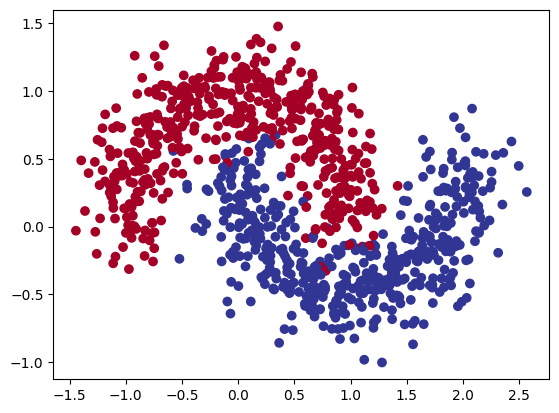

In [111]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt

plt.scatter(
    x = X[:,0],
    y = X[:,1],
    c=y,
    cmap=plt.cm.RdYlBu
);

In [112]:
# Turn data into tensors of dtype float
X_moon = torch.from_numpy(X).type(torch.float) # float 32
y_moon = torch.from_numpy(y).type(torch.float)

# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split

X_moon_train, X_moon_test, y_moon_train,y_moon_test = train_test_split(X_moon,
                                                                      y_moon,
                                                                      test_size=0.2,
                                                                       random_state=42)

In [113]:
X_moon_train.shape, y_moon_train.shape, X_moon_test.shape, y_moon_test.shape

(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]))

## 2. Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.


In [119]:
import torch
from torch import nn

# Inherit from nn.Module to make a model capable of fitting the mooon data
class MoonModelV0(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        ## Your code here ##
        return self.linear_layer_stack(x)

# Instantiate the model
model_moon = MoonModelV0(input_features=2,
                         output_features=1,
                         hidden_units=8)

model_moon

MoonModelV0(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

# 3. Setup a binary classification compatible loss function and optimizer to use when training the model built in 2.


In [120]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss() # ha già l'attivazione sigomoide

optimizer = torch.optim.SGD(params=model_moon.parameters(),
                            lr=0.1)
    

In [121]:
model_moon.to(device)
X_moon_train, y_moon_train = X_moon_train.to(device), y_moon_train.to(device)
X_moon_test, y_moon_test = X_moon_test.to(device), y_moon_test.to(device)

# 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.

In [122]:
# What's coming out of our model?

# logits (raw outputs of model)
print("Logits:")
print(model_moon(X_moon_train.to(device)[:10]).squeeze())

# Prediction probabilities
print("Pred probs:")
print(torch.sigmoid(model_moon(X_moon_train.to(device)[:10]).squeeze()))

# Prediction labels
print("Pred labels:")
print(torch.round(torch.sigmoid(model_moon(X_moon_train.to(device)[:10]).squeeze())))

Logits:
tensor([0.1878, 0.1325, 0.1844, 0.1781, 0.1736, 0.1690, 0.1867, 0.1685, 0.1865,
        0.1205], device='mps:0', grad_fn=<SqueezeBackward0>)
Pred probs:
tensor([0.5468, 0.5331, 0.5460, 0.5444, 0.5433, 0.5422, 0.5465, 0.5420, 0.5465,
        0.5301], device='mps:0', grad_fn=<SigmoidBackward0>)
Pred labels:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='mps:0',
       grad_fn=<RoundBackward0>)


In [123]:
# Let's calculuate the accuracy using accuracy from TorchMetrics
!pip -q install torchmetrics # Colab doesn't come with torchmetrics
from torchmetrics import Accuracy

## TODO: Uncomment this code to use the Accuracy function
acc_fn = Accuracy(task="multiclass", num_classes=2).to(device) # send accuracy function to device
acc_fn

MulticlassAccuracy()

In [125]:
## TODO: Uncomment this to set the seed
torch.manual_seed(RANDOM_SEED)

# Setup epochs
epochs = 1000

# Send data to the device


# Loop through the data
for epoch in range(epochs):
  ### Training
    model_moon.train()

  # 1. Forward pass (logits output)
    y_logits = model_moon(X_moon_train).squeeze()
  
  # Turn logits into prediction probabilities
    y_pred_probs = torch.sigmoid(y_logits)

  # Turn prediction probabilities into prediction labels
    y_pred = torch.round(y_pred_probs)

  # 2. Calculaute the loss
    loss = loss_fn(y_logits, y_moon_train) # loss = compare model raw outputs to desired model outputs

  # Calculate the accuracy
    acc = acc_fn(y_pred, y_moon_train.int()) # the accuracy function needs to compare pred labels (not logits) with actual labels

  # 3. Zero the gradients
    optimizer.zero_grad()

  # 4. Loss backward (perform backpropagation) - https://brilliant.org/wiki/backpropagation/#:~:text=Backpropagation%2C%20short%20for%20%22backward%20propagation,to%20the%20neural%20network's%20weights.
    loss.backward()
  # 5. Step the optimizer (gradient descent) - https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21#:~:text=Gradient%20descent%20(GD)%20is%20an,e.g.%20in%20a%20linear%20regression) 
    optimizer.step()

  ### Testing
    model_moon.eval() 
    with torch.inference_mode():
        # 1. Forward pass (to get the logits)
        test_logits = model_moon(X_moon_test).squeeze()
        # Turn the test logits into prediction labels
        test_pred_probs = torch.sigmoid(test_logits)
        test_pred = torch.round(test_pred_probs)

        # 2. Caculate the test loss/acc
        test_loss = loss_fn(test_logits, y_moon_test)
        test_acc = acc_fn(test_pred, y_moon_test.int())

    # Print out what's happening every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")


Epoch: 0 | Loss: 0.69 Acc: 0.50 | Test loss: 0.69 Test acc: 0.50
Epoch: 100 | Loss: 0.47 Acc: 0.82 | Test loss: 0.48 Test acc: 0.79
Epoch: 200 | Loss: 0.30 Acc: 0.87 | Test loss: 0.30 Test acc: 0.86
Epoch: 300 | Loss: 0.29 Acc: 0.87 | Test loss: 0.29 Test acc: 0.86
Epoch: 400 | Loss: 0.28 Acc: 0.87 | Test loss: 0.28 Test acc: 0.87
Epoch: 500 | Loss: 0.27 Acc: 0.88 | Test loss: 0.27 Test acc: 0.87
Epoch: 600 | Loss: 0.26 Acc: 0.88 | Test loss: 0.26 Test acc: 0.88
Epoch: 700 | Loss: 0.25 Acc: 0.89 | Test loss: 0.24 Test acc: 0.89
Epoch: 800 | Loss: 0.23 Acc: 0.90 | Test loss: 0.22 Test acc: 0.90
Epoch: 900 | Loss: 0.20 Acc: 0.92 | Test loss: 0.19 Test acc: 0.92


# 5. Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.


In [ ]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):
  
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/ 
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), 
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else: 
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary
    
    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

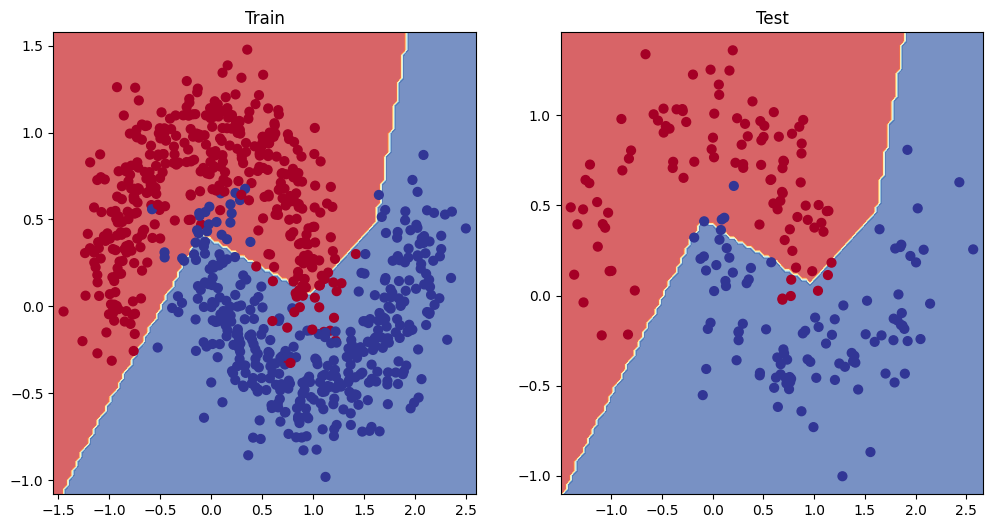

In [126]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_moon, X_moon_train, y_moon_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_moon, X_moon_test, y_moon_test)

# 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
Feel free to reference the [ML cheatsheet website](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh) for the formula.

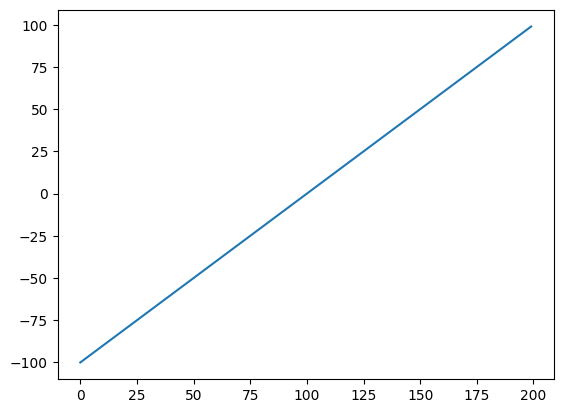

In [128]:

tensor_A = torch.arange(-100, 100, 1)
plt.plot(tensor_A)

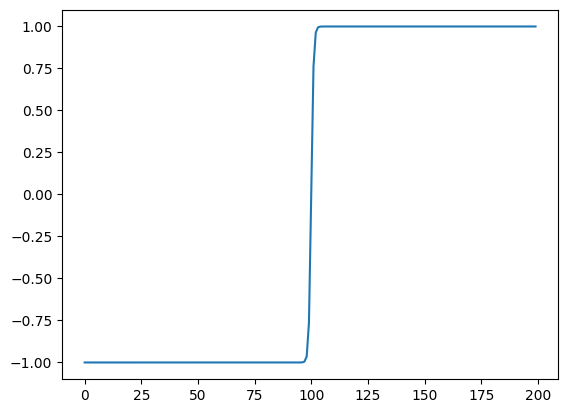

In [129]:
plt.plot(torch.tanh(tensor_A))


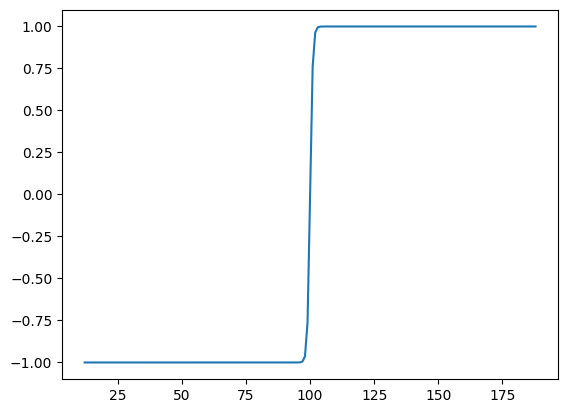

In [130]:
def tanh(x):
  # Source - https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh
  return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

plt.plot(tanh(tensor_A))

# 7. Create a multi-class dataset using the spirals data creation function from CS231n
- Split the data into training and test sets (80% train, 20% test) as well as turn it into PyTorch tensors.
- Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
- Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
- Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).
- Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.

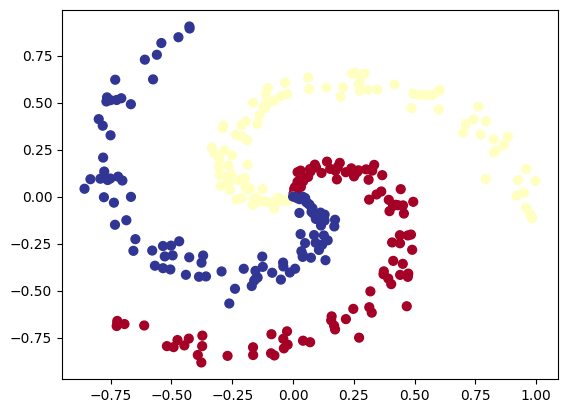

In [132]:
# Code for creating a spiral dataset from CS231n
import numpy as np
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [133]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
len(X_train), len(X_test), len(y_train), len(y_test)
     

(240, 60, 240, 60)

In [134]:
# Let's calculate the accuracy for when we fit our model
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=3).to(device) # send accuracy function to device
acc_fn
     

MulticlassAccuracy()

In [135]:
class SpiralModel(nn.Module): 
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(in_features=2, out_features=10)
    self.linear2 = nn.Linear(in_features=10, out_features=10)
    self.linear3 = nn.Linear(in_features=10, out_features=3)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.linear3(self.relu(self.linear2(self.relu(self.linear1(x)))))

model_1 = SpiralModel().to(device)
model_1

SpiralModel(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
)

In [136]:
# Setup data to be device agnostic
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
print(X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype)

# Print out untrained model outputs
print("Logits:")
print(model_1(X_train)[:10])

print("Pred probs:")
print(torch.softmax(model_1(X_train)[:10], dim=1))

print("Pred labels:")
print(torch.softmax(model_1(X_train)[:10], dim=1).argmax(dim=1))

torch.float32 torch.float32 torch.int64 torch.int64
Logits:
tensor([[-0.2160, -0.0600,  0.2256],
        [-0.2020, -0.0530,  0.2257],
        [-0.2223, -0.0604,  0.2384],
        [-0.2174, -0.0555,  0.2826],
        [-0.2201, -0.0502,  0.2792],
        [-0.2195, -0.0565,  0.2457],
        [-0.2212, -0.0581,  0.2440],
        [-0.2251, -0.0631,  0.2354],
        [-0.2116, -0.0548,  0.2336],
        [-0.2170, -0.0552,  0.2842]], device='mps:0', grad_fn=<SliceBackward0>)
Pred probs:
tensor([[0.2685, 0.3139, 0.4176],
        [0.2707, 0.3142, 0.4151],
        [0.2659, 0.3126, 0.4215],
        [0.2615, 0.3074, 0.4311],
        [0.2609, 0.3092, 0.4299],
        [0.2653, 0.3123, 0.4224],
        [0.2653, 0.3123, 0.4224],
        [0.2659, 0.3127, 0.4214],
        [0.2681, 0.3136, 0.4184],
        [0.2614, 0.3072, 0.4314]], device='mps:0', grad_fn=<SoftmaxBackward0>)
Pred labels:
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='mps:0')


In [137]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(),
                             lr=0.02)

In [138]:
# Build a training loop for the model
epochs = 1000

# Loop over data
for epoch in range(epochs):
  ## Training
  model_1.train()
  # 1. forward pass
  y_logits = model_1(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_pred, y_train)
  
  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. loss backwards
  loss.backward()

  # 5. optimizer step step step
  optimizer.step()

  ## Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    # 2. Caculate loss and acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")
     

Epoch: 0 | Loss: 1.12 Acc: 0.32 | Test loss: 1.10 Test acc: 0.37
Epoch: 100 | Loss: 0.45 Acc: 0.78 | Test loss: 0.53 Test acc: 0.68
Epoch: 200 | Loss: 0.12 Acc: 0.96 | Test loss: 0.09 Test acc: 0.98
Epoch: 300 | Loss: 0.07 Acc: 0.98 | Test loss: 0.02 Test acc: 1.00
Epoch: 400 | Loss: 0.05 Acc: 0.98 | Test loss: 0.01 Test acc: 1.00
Epoch: 500 | Loss: 0.04 Acc: 0.99 | Test loss: 0.01 Test acc: 1.00
Epoch: 600 | Loss: 0.03 Acc: 0.99 | Test loss: 0.01 Test acc: 1.00
Epoch: 700 | Loss: 0.03 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 800 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 900 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00


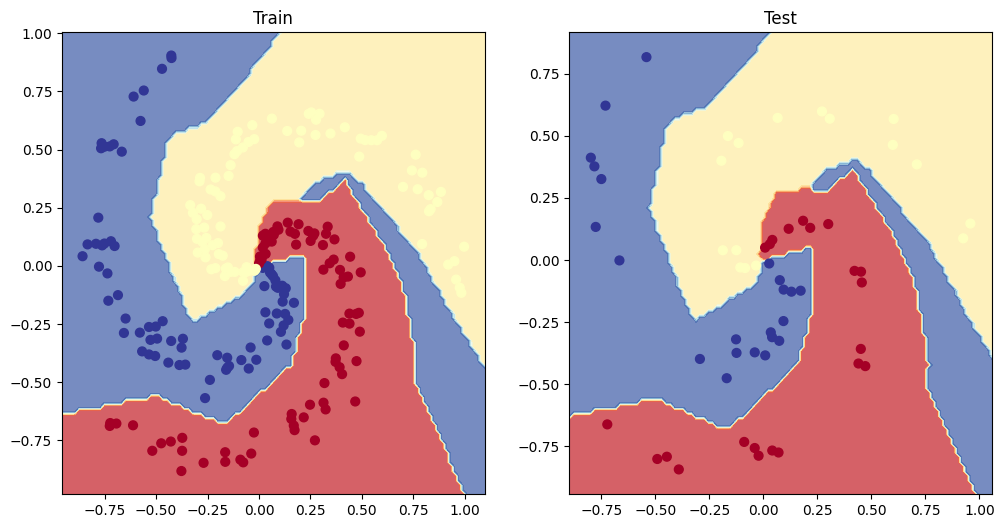

In [139]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)